In [2]:
dir = 'D:/projects/datascience/bfu-ml-labs/lab_5.1_and_5.2'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv(f'{dir}/diabetes.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [41]:
ill = 100. * len(df[df['Outcome'] == 1]) / len(df)
print(f"Больных диабетом в датасете: {ill}%")

Больных диабетом в датасете: 34.895833333333336%


In [6]:
from sklearn.model_selection import train_test_split

X = df.drop(['Outcome'], axis=1)
y = df['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [7]:
from sklearn.metrics import classification_report

# ЛР 5.1

In [8]:
from sklearn.linear_model import LogisticRegression

model_1 = LogisticRegression()
model_1.fit(X_train, y_train)
y_pred_1 = model_1.predict(X_test)
print(classification_report(y_test, y_pred_1))

              precision    recall  f1-score   support

           0       0.79      0.89      0.84       102
           1       0.72      0.54      0.62        52

    accuracy                           0.77       154
   macro avg       0.75      0.72      0.73       154
weighted avg       0.77      0.77      0.76       154



D:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [9]:
from sklearn.tree import DecisionTreeClassifier

model_2 = DecisionTreeClassifier()
model_2.fit(X_train, y_train)
y_pred_2 = model_2.predict(X_test)
print(classification_report(y_test, y_pred_2))

              precision    recall  f1-score   support

           0       0.80      0.76      0.78       102
           1       0.58      0.63      0.61        52

    accuracy                           0.72       154
   macro avg       0.69      0.70      0.69       154
weighted avg       0.73      0.72      0.72       154



### Сравнение

Метрика **Accuracy** у обеих моделей примерно на одном уровне.

Однако, мы хотим предупреждать диабет. Болезни лучше выявлять как можно раньше. И лучше "перебдеть", чем "недобдеть" в этом плане: пусть лучше пара здоровых людей лишний раз обследуются, чем будет отправлен домой с вердиктом "здоров" действительно больной человек. Поэтому в данном случае особенно важен показатель **Recall** — доля больных людей, которых модель правильно классифицировала как таковых.

И вот тут дерево решений, `model_2`, дала заметно лучший результат (63% против 57%). Скорее всего, это связано с нелинейным характером зависимости между целевой переменной ("болен?") и признаками (артериальное давление, уровень инсулина...). В таких ситуациях деревья решений должны справляться лучше.

In [61]:
random_state = 123

In [62]:
from sklearn.model_selection import validation_curve


metric = 'recall'


def experiment_with_model_hyperparameter(model, param_name, param_range_start, param_range_end):
    param_range = np.arange(param_range_start, param_range_end)

    train_scores, test_scores = validation_curve(
        model,
        X,
        y,
        param_name=param_name,
        param_range=param_range,
        cv=10,
        scoring=metric,
    )

    train_scores_mean = train_scores.mean(axis=1)
    test_scores_mean = test_scores.mean(axis=1)
    train_scores_std = train_scores.std(axis=1)
    test_scores_std = test_scores.std(axis=1)

    print(test_scores.max())

    plt.figure(figsize=(10, 5))

    plt.plot(param_range, train_scores_mean, label='Train')
    plt.plot(param_range, test_scores_mean, label='Test')
    plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.25)
    plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.25)

    plt.xticks(param_range)
    plt.yticks(np.arange(0., 1., 0.05))
    plt.xlabel(param_name)
    plt.ylabel(metric)
    plt.legend()
    plt.show()

0.7692307692307693


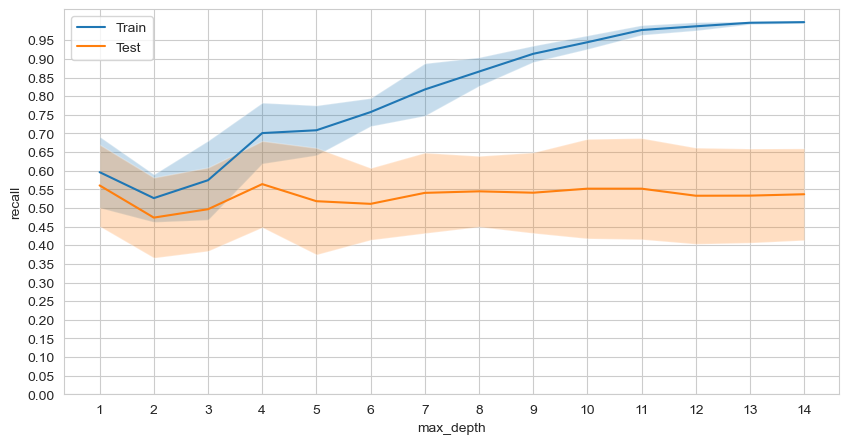

In [66]:
experiment_with_model_hyperparameter(
    DecisionTreeClassifier(random_state=random_state),
    'max_depth', 1, 15
)

In [67]:
# Ещё в начале установили, что больных примерно втрое меньше, чем здоровых. Это негативно сказывается
# на качестве модели. Нам крайне важно точно угадывать больных, поэтому утроим вес этого класса.
class_weight = {0: 1., 1: 3.}

0.9629629629629629


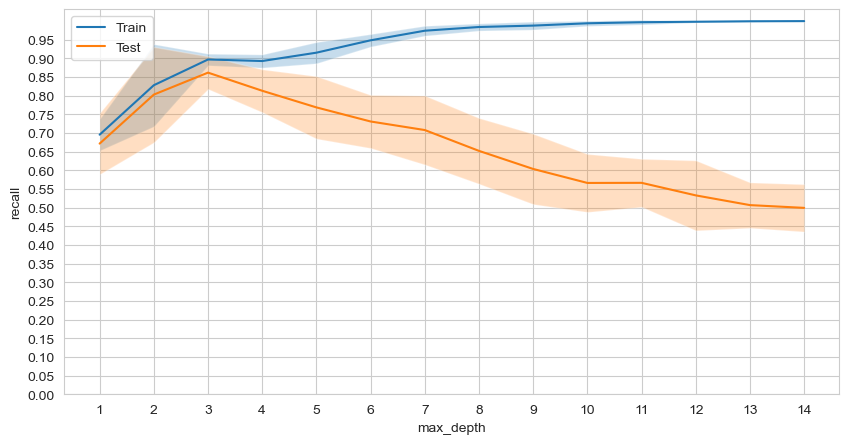

In [68]:
experiment_with_model_hyperparameter(
    DecisionTreeClassifier(random_state=random_state, class_weight=class_weight),
    'max_depth', 1, 15
)

In [69]:
max_depth = 3

0.9629629629629629


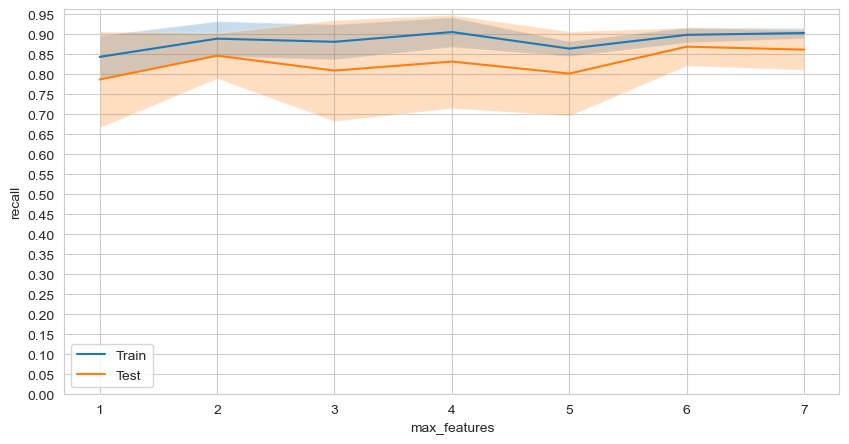

In [70]:
experiment_with_model_hyperparameter(
    DecisionTreeClassifier(random_state=random_state, class_weight=class_weight, max_depth=max_depth),
    'max_features', 1, X.shape[1]
)

In [72]:
max_features = 6

In [73]:
good_tree = DecisionTreeClassifier(
    random_state=random_state,
    class_weight=class_weight,
    max_depth=max_depth,
    max_features=max_features
)
good_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={0: 1.0, 1: 3.0}, max_depth=3,
                       max_features=6, random_state=123)

In [80]:
from graphviz import Source
from sklearn.tree import export_graphviz

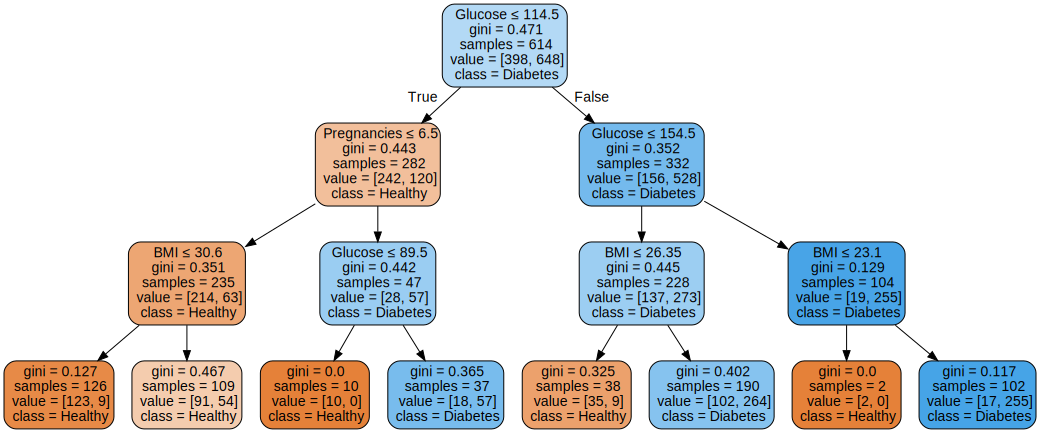

In [103]:
dot_data = export_graphviz(
    good_tree,
    out_file=None,
    feature_names=X.columns,
    class_names=['Healthy', 'Diabetes'],
    filled=True,
    rounded=True,
    special_characters=True
)
graph = Source(dot_data)
graph.format = 'png'
graph.render('tree', view=True)  # откроет большое изображение в системной программе для просмотра изображений по умолчанию
graph

Text(0.5, 1.0, 'Feature Importances')

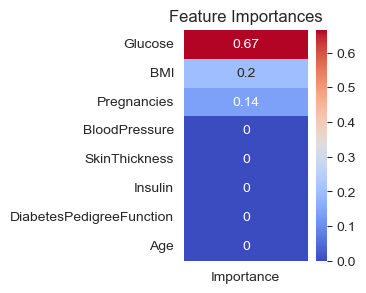

In [105]:
import seaborn as sns

plt.figure(figsize=(2, 3))
imp = pd.DataFrame(good_tree.feature_importances_,
                   index=X.columns,
                   columns=['Importance']).sort_values('Importance', ascending=False)
sns.heatmap(imp, annot=True, cmap='coolwarm')
plt.title('Feature Importances')

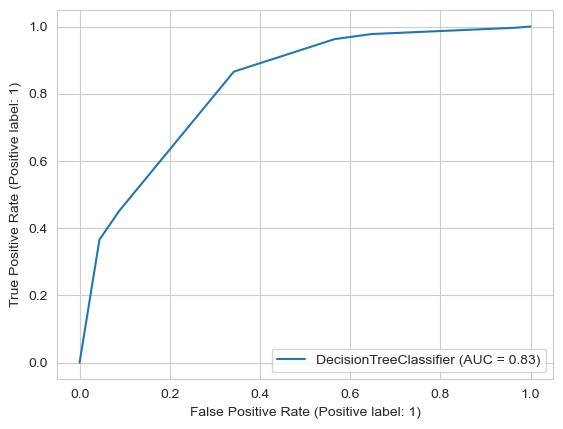

In [106]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(good_tree, X, y)

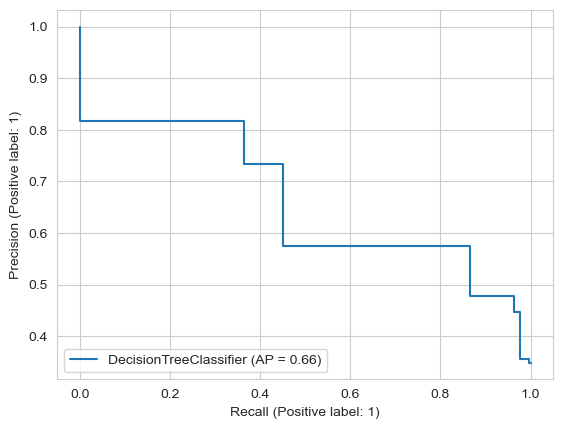

In [107]:
from sklearn.metrics import PrecisionRecallDisplay

PrecisionRecallDisplay.from_estimator(good_tree, X, y)

In [109]:
print(classification_report(y_test, good_tree.predict(X_test)))

              precision    recall  f1-score   support

           0       0.85      0.67      0.75       102
           1       0.54      0.77      0.63        52

    accuracy                           0.70       154
   macro avg       0.70      0.72      0.69       154
weighted avg       0.75      0.70      0.71       154



### С такой моделью (`good_tree`) мы можем успешно предупреждать развитие диабета более чем в 80% случаях, ложно отправляя на дополнительное обследование примерно каждого третьего здорового человека. Не отлично, но уже лучше, чем простая логистическая регрессия или дерево решений со стандартными значениями гиперпараметров.

# ЛР 5.2

## Задание 1 (случайный лес)

In [110]:
from sklearn.ensemble import RandomForestClassifier

1.0


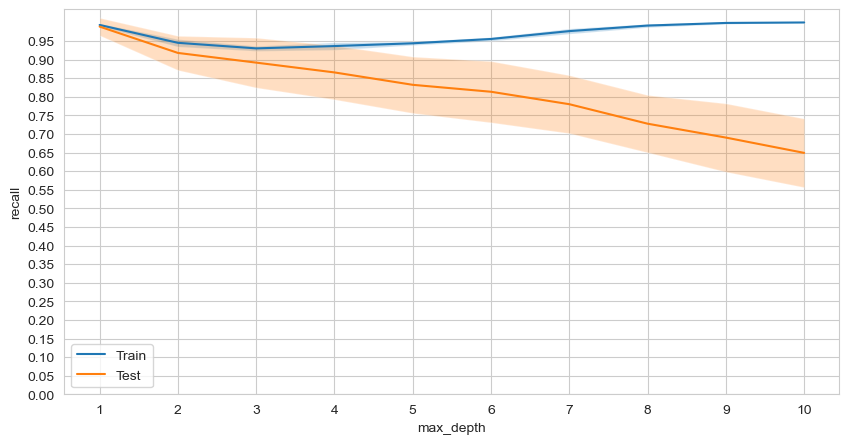

In [112]:
experiment_with_model_hyperparameter(
    RandomForestClassifier(random_state=random_state, class_weight=class_weight),
    'max_depth', 1, 11
)

In [134]:
max_depth = 3  # даёт неплохой баланс между recall и precision

1.0


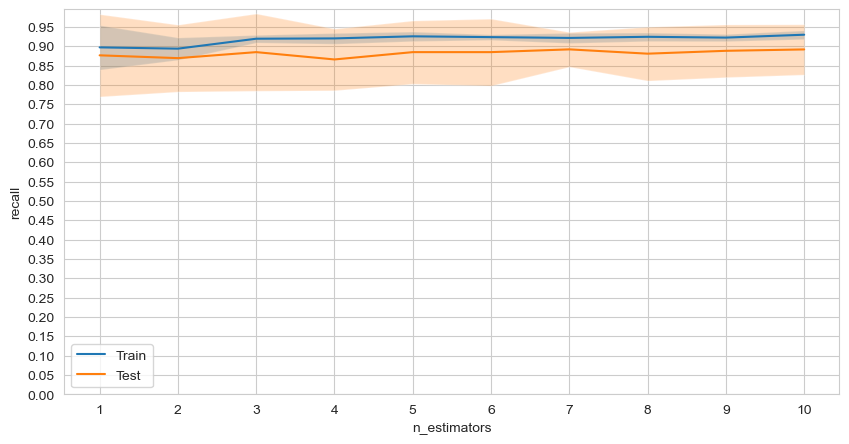

In [155]:
n_estimators_range = (1, 11)
experiment_with_model_hyperparameter(
    RandomForestClassifier(random_state=random_state, class_weight=class_weight, max_depth=max_depth),
    'n_estimators', *n_estimators_range
)

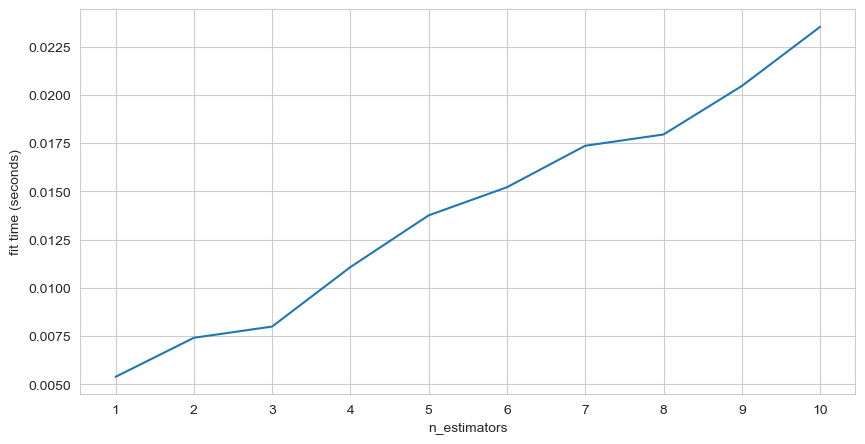

In [162]:
# Замеряем время обучения для каждой допустимой глубины деревьев в лесу.

import time

n_est_values = list(range(*n_estimators_range))
times_elapsed = []

for n_est in n_est_values:
    t_begin = time.perf_counter()
    model_n_est = RandomForestClassifier(
        random_state=random_state,
        class_weight=class_weight,
        max_depth=max_depth,
        n_estimators=n_est  # с этим экспериментируем
    )
    model_n_est.fit(X_train, y_train)
    t_end = time.perf_counter()
    t_elapsed = t_end - t_begin
    times_elapsed.append(t_elapsed)

plt.figure(figsize=(10, 5))
plt.plot(n_est_values, times_elapsed)
plt.xticks(n_est_values)
plt.xlabel("n_estimators")
plt.ylabel("fit time (seconds)")
plt.show()

In [137]:
n_estimators = 3

1.0


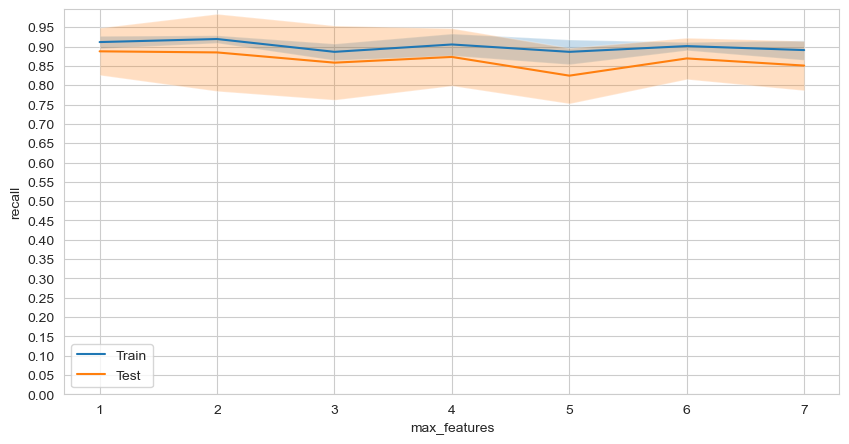

In [140]:
experiment_with_model_hyperparameter(
    RandomForestClassifier(random_state=random_state, class_weight=class_weight, max_depth=max_depth, n_estimators=n_estimators),
    'max_features', 1, X.shape[1]
)

In [153]:
max_features = 2

In [154]:
good_forest = RandomForestClassifier(
    random_state=random_state,
    class_weight=class_weight,
    max_depth=max_depth,
    n_estimators=n_estimators,
    max_features=max_features,
)
good_forest.fit(X_train, y_train)
print(classification_report(y_test, good_forest.predict(X_test)))

              precision    recall  f1-score   support

           0       0.86      0.47      0.61       102
           1       0.45      0.85      0.59        52

    accuracy                           0.60       154
   macro avg       0.65      0.66      0.60       154
weighted avg       0.72      0.60      0.60       154



### Случайный лес с подобранными параметрами чаще выявляет действительно больных пациентов, однако также чаще подвержен ложным срабатываниям. Более того, при полученных параметрах более половины здоровых людей будут вынуждены проходить доп. обследование, которое может быть дорогостоящим или времязатратным. При этом recall не так уж и высок (85%) -- мне кажется, для такого количества ложноположительных срабатываний это -- такой себе результат.

## Задание 2 (XGBoost)

In [191]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

xgbc_param_grid = {
    'n_estimators': [10, 50],
    'max_depth': [5, 10],
    'learning_rate': [0.1, 0.3],
    'gamma': [0.3, 0.6],
    'reg_lambda': [1., 10.],
    'reg_alpha': [1., 10.],
    'subsample': [0.5, 1.],
}

xgbc_grid_search = GridSearchCV(
    XGBClassifier(objective='binary:logistic'),
    xgbc_param_grid,
    cv=10,
    scoring='recall'
)
xgbc_grid_search.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             param_grid={'gamma': [0.3, 0.6], 'learning_rate': [0.1, 0.3],
                         'max_depth': [5, 10], 'n_estimators': [10, 50],
                         'reg_alpha': [1.0, 10.0], 'reg_lambda': [1.0, 10.0],
                         'subsample': [0.5, 1.0]},
             scoring='recall')

In [192]:
xgbc_grid_search.best_params_

{'gamma': 0.3,
 'learning_rate': 0.3,
 'max_depth': 10,
 'n_estimators': 10,
 'reg_alpha': 1.0,
 'reg_lambda': 1.0,
 'subsample': 1.0}

In [193]:
xgbc_grid_search.best_score_

0.6660173160173161

In [194]:
print(classification_report(y_test, xgbc_grid_search.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           0       0.80      0.82      0.81       102
           1       0.63      0.60      0.61        52

    accuracy                           0.75       154
   macro avg       0.72      0.71      0.71       154
weighted avg       0.74      0.75      0.74       154



### XGBoost с подобранными параметрами дал неплохую точность в среднем, однако recall у него слабоват (около 60%). И это при том, что параметры подбирались под оптимизацию именно этой метрики. Возможно, стоит попробовать другие допустимые наборы значений гиперпараметров. А, может, градиентный бустинг в этой задаче просто хуже.

In [195]:
# Замеряем отдельно время на обучение лучшей XGBoost модели.

t_begin = time.perf_counter()
good_xgbc = xgbc_grid_search.best_estimator_
good_xgbc.fit(X_train, y_train)
t_end = time.perf_counter()
t_elapsed = t_end - t_begin
t_elapsed

0.019608200000220677

### Получается, в этом случае (при таких подобранных комбинациях гиперпараметров) случайный лес оказалось ещё и "дешевле" обучать. Но, вероятно, дело просто в тонкости и трудности подбора хороших гиперпараметров (особенно для XGBoost-модели).

### В целом, как мне кажется, лучшей из полученных в рамках этой работы моделью оказалась `good_tree` (как по точности, так и по эффективности/времени обучения).